<a href="https://colab.research.google.com/github/MilanCugur/PUBLISH_ME/blob/master/CVL_Single_Digit_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np
from zipfile import ZipFile

from keras.utils import Sequence
from random import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import cv2
from sklearn.utils import shuffle

Using TensorFlow backend.


# Load Dataset

In [3]:
%%time
# Extract images to 'ImageDisk' folder

path = './drive/My Drive/CVL_datasets/CVL_Single_Digits_Dataset.zip'  # Different .zip folder with images
archive = ZipFile(path, 'r')
archive.extractall('./ImageDisk')  
archive.close()

CPU times: user 4.45 s, sys: 2.04 s, total: 6.49 s
Wall time: 8.12 s


In [4]:
!cat './ImageDisk/cvl-single-digits/readme-single.txt'

The CVL Single Digit dataset consists of 7000 single digits (700 digits per class) written by approximately 60 different writers. The validation set has the same size but different writers. The validation set may be used for parameter estimation and validation but not for supervised training. 

File Naming:
The numbers before the first minus are the respective class labels succeeded by an unique ID.

	* 2-0202-21-04.png is an image that contains a single digit with groundtruth 2
	* 135579-0001-10.png is an image that contains the digit string 135579


# OneHot

In [0]:
# OneHot Encoding
class OneHot():  
  # classes = list of classes : 0-9, a-z, A-Z
  # n = number of classes     : 62
  
  def __init__(self, classes):
    self.classes = classes
    self.n = len(classes)
    
  def encode(self, class_name):
    one_hot = np.zeros(shape=(self.n), dtype=np.int8)
    class_index = self.classes.index(class_name)
    one_hot[class_index] = 1
    return one_hot
  
  def encode_all(self, list_class_names):
    return np.array([self.encode(class_name) for class_name in list_class_names])
  
  def decode(self, one_hot):
    class_index = one_hot.argmax()
    return self.classes[class_index]
  
  def decode_all(self, list_one_hots):
    return np.array([self.decode(one_hot) for one_hot in list_one_hots])

In [6]:
labels = set(np.arange(0, 10))

print(sorted(labels))  # 62 ascii codes in string format
print(len(labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10


In [0]:
OH_L = OneHot(sorted(labels))

# Load Train/Validation/Test 

In [0]:
#!ls './ImageDisk/cvl-single-digits/train/'

(48, 29, 3)


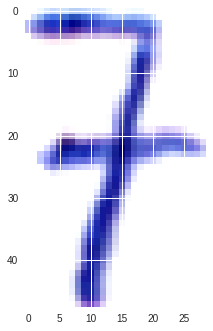

In [9]:
# Read image as RGB
PATH = './ImageDisk/cvl-single-digits/train/7-0213-01-01.png'
img = io.imread(PATH)
print(img.shape)
plt.imshow(img)
plt.show()

(48, 29)


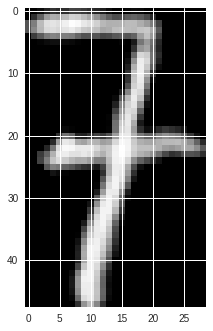

In [10]:
# Read image as Grayscale
PATH = './ImageDisk/cvl-single-digits/train/7-0213-01-01.png'
img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)

print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
from skimage import color, io, transform  # import modules for visualise image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random  # random choose
import cv2  # image processing
from scipy import ndimage

BOX_SIZE = 56
PADDING = 2

def read_gray(path):  # read image and convert it to grayscale
  """
  return grayscale image in shape (128, 128)
  """
  img = io.imread(path) 
  img = color.rgb2gray(img)
  return img

def add_noise(img, noise_function): 
  """
  return noised image
  """
  return noise_function(img)

def add_gaussian_noise(img, sigma=2):
  """
  add Gaussian filter to image
  Use default params: sigma=1
  """
  return ndimage.gaussian_filter(img, sigma=sigma)

def square_image(img):
  """
  return image squared to bigger dimension: max(height, width) x max(height, width)
  """
  height, width = img.shape
  box_size = max(height, width)  
  new_img = np.ones(shape=(box_size, box_size))

  left = (box_size-height)//2  # calculate translation factor
  right = (box_size-width)//2

  new_img[left:left+height, right:right+width] = img  # position image to center of square image
  return new_img

def resize_image(img, interp):
  """
  resize image with appropriate interpolation
  Use of global object: BOX_SIZE
  """
  new_img = np.zeros(shape=(BOX_SIZE, BOX_SIZE), dtype=np.uint8)
  new_img.fill(255)
  tmp_img = cv2.resize(src=img, dsize=(BOX_SIZE, BOX_SIZE), interpolation=interp)  # imresize with bicubic interpolation
  return tmp_img

def to8bit(img):  
  """
  convert binary image to 8bit gray image
  """
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img[i][j] = int(min(img[i][j], 1)*255)  # use max(1,..) to handle small numeric errors
  return img

import functools
def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)
  
def parse_image(interp, noise_function):
  """
  return image parser with desired interpolation and noise function
  """
  parser = compose(to8bit, functools.partial(resize_image, interp=interp), square_image, functools.partial(add_noise, noise_function=noise_function), read_gray)
  return parser

In [0]:
parser = parse_image(cv2.INTER_AREA, add_gaussian_noise)

(56, 56)


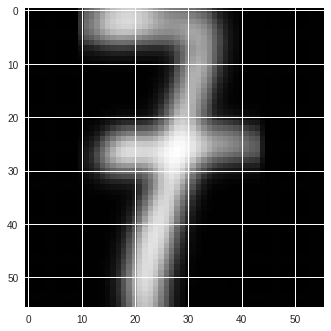

In [13]:
# Read image with tools
PATH = './ImageDisk/cvl-single-digits/train/7-0213-01-01.png'
img = parser(PATH)

print(img.shape)
plt.imshow(img)
plt.show()

(56, 56)


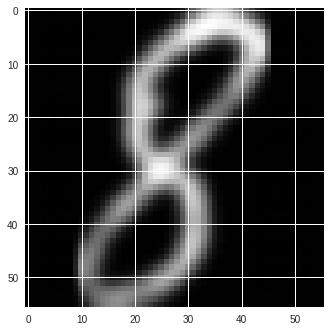

In [14]:
PATH = './ImageDisk/cvl-single-digits/valid/8-0073-13-06.png'
img = parser(PATH)

print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
TRAINPATH = './ImageDisk/cvl-single-digits/train'
VALIDPATH = './ImageDisk/cvl-single-digits/valid'
TESTPATH = './ImageDisk/cvl-single-digits/eval'

In [0]:
def read_data(dirpath):
  """
  read data from entire directory of .png format images
  return ordered triple: images, labels, writers
  """
  images = []
  labels = []
  writers = []
  
  for imgpath in os.listdir(dirpath):
    fullpath = os.path.join(dirpath, imgpath)
    images.append(parser(fullpath))
    labels.append(int(imgpath.split('-')[0]))
    writers.append(int(imgpath.split('-')[1]))
    
  images, labels = shuffle(images, labels)  # shuffle together
    
  images = np.array(images)
  images = images.reshape(images.shape[0], BOX_SIZE, BOX_SIZE, 1)
  images = images.astype('float32')
  images /= 255
  
  return images, OH_L.encode_all(labels), writers

In [17]:
%%time 
train_images, train_labels, train_writers = read_data(TRAINPATH)

CPU times: user 37 s, sys: 487 ms, total: 37.5 s
Wall time: 37.6 s


In [18]:
print(train_images.shape)
print(train_labels.shape)
print('no samples: ', len(train_writers))
print('no writers: ', len(set(train_writers)))

(7000, 56, 56, 1)
(7000, 10)
no samples:  7000
no writers:  67


In [19]:
%%time 
valid_images, valid_labels, valid_writers = read_data(VALIDPATH)

CPU times: user 35.9 s, sys: 339 ms, total: 36.2 s
Wall time: 36.3 s


In [20]:
print(valid_images.shape)
print(valid_labels.shape)
print('no samples: ', len(valid_writers))
print('no writers: ', len(set(valid_writers)))

(7000, 56, 56, 1)
(7000, 10)
no samples:  7000
no writers:  60


In [21]:
%%time 
test_images, test_labels, test_writers = read_data(TESTPATH)

CPU times: user 1min 46s, sys: 1.26 s, total: 1min 47s
Wall time: 1min 47s


In [22]:
print(test_images.shape)
print(test_labels.shape)
print('no samples: ', len(test_writers))
print('no writers: ', len(set(test_writers)))

(21780, 56, 56, 1)
(21780, 10)
no samples:  21780
no writers:  176


[0 0 0 1 0 0 0 0 0 0]
200
(56, 56, 1)


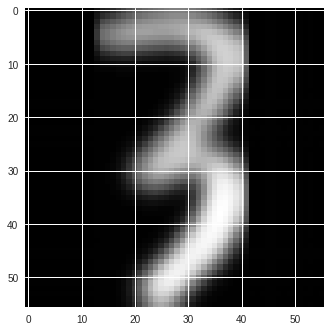

In [23]:
img = train_images[0]
print(train_labels[0])
print(train_writers[0])
print(img.shape)
plt.imshow(img.reshape(BOX_SIZE, BOX_SIZE))
plt.show()

In [0]:
#trainvalid_images = np.concatenate((train_images, valid_images), axis=0)
#trainvalid_images.shape
# standardize data
#from sklearn import preprocessing
#
#scaler_tv = preprocessing.StandardScaler()
#scaler_tv.fit(trainvalid_images.reshape(-1, BOX_SIZE, BOX_SIZE))
#x_train = scaler_tv.transform(x_train)
#x_valid = scaler_tv.transform(x_valid)

# Model

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam  # First, naive approach
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger  # Add callbacks to model
from keras.models import load_model  # Save model params
from keras.layers import LeakyReLU, concatenate
from keras.layers.advanced_activations import PReLU
from keras.initializers import glorot_normal
from keras import regularizers
from keras.activations import relu

import keras.backend as K

In [0]:
#BOX_SIZE = 56                          # (56, 56) images; fixed size; I already preprocessed it
image_shape = (BOX_SIZE, BOX_SIZE, 1)  # (56, 56, 1) shape for tensorflow
number_of_classes = len(labels)        # 10 classes; 0-9

In [27]:
x_input = Input(shape=image_shape)  # shape=(?, 56, 56, 1)

x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation=relu, padding='valid')(x_input)  
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation=relu, padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), padding='same')(x)                                                     
x = Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation=relu, padding='valid')(x)        
x = Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation=relu, padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), padding='same')(x)                                                    
x = Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), activation=relu, padding='valid')(x)       
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation=relu, padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), padding='same')(x)                                                     
x = Flatten()(x)                                                                                       

x = Dense(units=768, activation=relu, kernel_regularizer=regularizers.l2(0.02))(x)        
x = Dropout(rate=0.3)(x)

x = Dense(units=512, activation=relu, kernel_regularizer=regularizers.l2(0.03))(x)                           
x = Dropout(rate=0.5)(x) 

x = Dense(units=256, name='next_to_last', kernel_regularizer=regularizers.l2(0.02))(x)                           
x = Dropout(rate=0.3)(x)                          

y_output = Dense(units=number_of_classes, activation='softmax')(x)  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
recognizer = Model(inputs=x_input, outputs=y_output, name='recognizer')

In [29]:
recognizer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 52, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 48)        13872     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 48)        20784     
__________

In [0]:
recognizer.compile(optimizer=Adam(lr=1e-3), loss=categorical_crossentropy, metrics=['accuracy'])   # beta_1=0.9, beta_2=0.999

In [0]:
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='min', #add min_delta
                           cooldown=1, min_le=1e-8)

estop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

excel = CSVLogger(filename='./baseline_hacked.csv', separator=',', append=False)

checkp = ModelCheckpoint('./best_w.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

In [32]:
history = recognizer.fit(x=train_images, y=train_labels,
                         batch_size=256, epochs=10, verbose=1, 
                         callbacks=[reduce, estop, excel, checkp], 
                         validation_data=(valid_images, valid_labels),          
                         shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 7000 samples, validate on 7000 samples
Epoch 1/10
7000/7000 [==============================] - 9s 1ms/step - loss: 31.4907 - acc: 0.5830 - val_loss: 21.8699 - val_acc: 0.6571

Epoch 00001: val_loss improved from inf to 21.86986, saving model to ./best_w.h5
Epoch 2/10
7000/7000 [==============================] - 4s 572us/step - loss: 15.4665 - acc: 0.8717 - val_loss: 10.2871 - val_acc: 0.8791

Epoch 00002: val_loss improved from 21.86986 to 10.28706, saving model to ./best_w.h5
Epoch 3/10
7000/7000 [==============================] - 4s 570us/step - loss: 7.3547 - acc: 0.9220 - val_loss: 5.2050 - val_acc: 0.8439

Epoch 00003: val_loss improved from 10.28706 to 5.20498, saving model to ./best_w.h5
Epoch 4/10
7000/7000 [==============================] - 4s 568us/step - loss: 3.6414 - acc: 0.9430 - val_loss: 3.4401 - val_acc: 0.6161

Epoch 00004: val_loss improved from 5.20498 to 3.44010, saving model to ./best_w.h5
Epoch 5/10
7000/70

In [33]:
recognizer.evaluate(x=test_images, y=test_labels, batch_size=256, verbose=1)

21780/21780 [==============================] - 3s 146us/step


[0.9512300308742471, 0.84389348027901]

# Loss plot

In [34]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


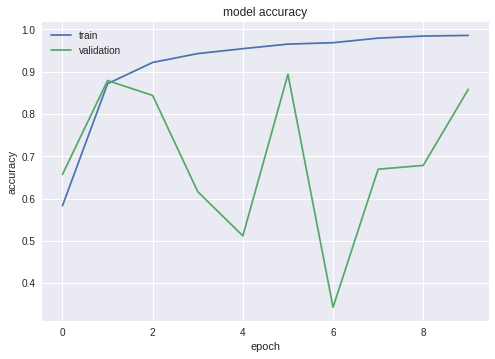

In [35]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

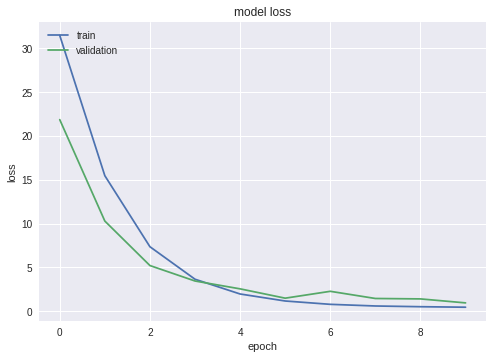

In [36]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Save weights

In [37]:
recognizer.input

<tf.Tensor 'input_1:0' shape=(?, 56, 56, 1) dtype=float32>

In [38]:
recognizer.get_layer('next_to_last').output

<tf.Tensor 'next_to_last/BiasAdd:0' shape=(?, 256) dtype=float32>

In [0]:
finder = Model(inputs=recognizer.input, outputs=recognizer.get_layer('next_to_last').output)

# Clustering by instances

In [40]:
print(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [41]:
IVectors = {}  # Ascii code is key, 48, 49, 50, ...
for l in labels:
  IVectors[l] = []
print(IVectors)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}


In [42]:
%%time

for k in range(0, len(train_images)):
  l = int(OH_L.decode(train_labels[k]))
  next_to_last = finder.predict(np.array([train_images[k]]))[0]
  IVectors[l].append(next_to_last)

CPU times: user 18.2 s, sys: 1.69 s, total: 19.9 s
Wall time: 14.7 s


In [43]:
%%time

for k in range(0, len(valid_images)):
  l = int(OH_L.decode(valid_labels[k]))
  next_to_last = finder.predict(np.array([valid_images[k]]))[0]
  IVectors[l].append(next_to_last)

CPU times: user 18.3 s, sys: 1.76 s, total: 20.1 s
Wall time: 14.9 s


In [44]:
S = 0
for l in IVectors.keys():
  S += len(IVectors[l])
print(S)

14000


In [45]:
print([len(IVectors[l]) for l in labels])  # broj slika po svakoj labeli

[1400, 1400, 1400, 1400, 1400, 1400, 1400, 1400, 1400, 1400]


In [0]:
from sklearn.cluster import KMeans
ICentroids = {}  # dictionary with centroids for each label
kmeans = None

In [47]:
%%time

for i, l in enumerate(labels):
  if kmeans!=None:
    del kmeans
  kmeans = KMeans(n_clusters=10, n_init=10, max_iter=300, tol=1e-4, precompute_distances=False, verbose=0)  # 15, 250/10, 300
  
  kmeans.fit(IVectors[l])
  ICentroids[l] = kmeans.cluster_centers_

CPU times: user 8.14 s, sys: 4.83 s, total: 13 s
Wall time: 6.59 s


In [48]:
ICentroids[0].shape  # Clusters for 'A'; small check

(10, 256)

In [0]:
# Normalize clusters; Newly added; Quick fix, small improvements; Normalize together ???
for k in ICentroids.keys(): 
  for j in range(0, ICentroids[k].shape[0]):
    ICentroids[k][j] = (ICentroids[k][j] - ICentroids[k][j].mean())/(ICentroids[k][j].std())

In [50]:
from sklearn.neighbors import KNeighborsClassifier  # Estimate the quality of custers
from sklearn.metrics import accuracy_score

Ns = [1,2,3,4,5,7,8,9,10,15]

X_train = []
y_train = []

for l in labels:
  for j in range(0, ICentroids[l].shape[0]):
    X_train.append(ICentroids[l][j])
    y_train.append(l)

for n in Ns:
  knn = KNeighborsClassifier(n_neighbors=n, metric='l2')
  knn.fit(X_train, y_train)
  
  score = accuracy_score(knn.predict(finder.predict(np.array(test_images))), [int(x) for x in OH_L.decode_all(test_labels)])
  print('KNN', n, ': ', score)
  del knn

KNN 1 :  0.9226813590449954
KNN 2 :  0.9037649219467401
KNN 3 :  0.909366391184573
KNN 4 :  0.9039944903581267
KNN 5 :  0.9067493112947659
KNN 7 :  0.9005509641873278
KNN 8 :  0.9006427915518824
KNN 9 :  0.8980257116620753
KNN 10 :  0.8960973370064279
KNN 15 :  0.887465564738292


# Density class

In [0]:
import numpy as np
from  scipy import stats
from matplotlib import pyplot as plt

# approximating theta parametar - how much I believe in network/knn (initially 0.5)

class CharStatistic():
  # label
  # alpha = 1 (initial)
  # beta = 1 (initial)
  
  def __init__(self, label, alpha=None, beta=None):
    self.label = label
    
    if alpha is not None:
      self.alpha = alpha
    else:
      self.alpha = 1
    if beta is not None:
      self.beta = beta
    else:
      self.beta = 1 # hardcoded initial; start with uniform distribution U[0, 1]
   
  def get_alpha(self):  # getters
    return self.alpha
  
  def get_beta(self):
    return self.beta
  
  def set_alpha(self, alpha):
    self.alpha = alpha
    
  def set_beta(self, beta):
    self.beta = beta
  
  def get_mean(self):
    return self.alpha/(self.alpha+self.beta)  # initaially 0.5
    # return stats.beta.mean(self.alpha, self.beta)
  
  def get_standard_deviation(self):
    return np.sqrt(self.alpha*self.beta/((self.alpha+self.beta)**2*(self.alpha+self.beta+1)))  # initially 0.1
    # return stats.beta.std(self.alpha, self.beta)
  
  def update_one(self, winnew):  # winnew==1 if knn wins, else its 0
    self.alpha += winnew
    self.beta += 1 - winnew
    
  def update_all(self, winnews):  # winnews = [1, 0, 1, ..] 1 if knn wins else 0
    N = len(winnews)
    z = sum(winnews)
    self.alpha += z
    self.beta += N - z
    
  def print_current_density_function(self):  # print current approximation of beta distribution
    x = np.linspace(0, 1, 100)
    y = stats.beta.pdf(x, self.alpha, self.beta)
    plt.xlabel("Density approximation for LABEL: "+self.label)
    plt.ylabel("Density")
    plt.plot(x, y)
    plt.fill_between(x, 0, y, color="#aaaadd", alpha=0.5)
    plt.tight_layout()
    plt.show()
  
  # FUNCTIONS FOR DECISION MAKING, WHOM TO TRUST:
    
  def __gt__(self, otherCharStatistic):  # Override operator > on density approximation
    if not isinstance(otherCharStatistic, CharStatistic):
      raise ValueError("Error. Operator overloaded for CharStatistic class")
    if self.get_mean()>otherCharStatistic.get_mean(): # TODO: USE .get_standard_deviation()
      return True
    else:
      return False

# With Stratify, Multiple k idea

In [52]:
print(labels)  
print(len(labels))

testset = set(test_writers)
print(len(testset))  # No of different writers

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
10
176


In [0]:
TESTDATA = {} 
for writer in testset:
  TESTDATA[writer] = [[], []]
for i in range(0, len(test_writers)):
    TESTDATA[test_writers[i]][0].append(test_images[i])
    TESTDATA[test_writers[i]][1].append(test_labels[i])

In [54]:
len(TESTDATA.keys())  # no of test writers
for writer in TESTDATA.keys():
  print(writer, ':', len(TESTDATA[writer][0]))

519 : 55
520 : 127
522 : 124
524 : 112
525 : 126
527 : 121
528 : 137
410 : 136
530 : 136
534 : 128
535 : 118
538 : 56
539 : 133
540 : 138
541 : 111
921 : 124
547 : 100
548 : 95
549 : 138
550 : 137
556 : 135
558 : 137
560 : 100
561 : 77
562 : 131
564 : 133
565 : 122
566 : 77
567 : 125
568 : 89
570 : 117
571 : 116
573 : 115
575 : 133
577 : 122
578 : 129
580 : 140
582 : 117
585 : 147
1101 : 132
592 : 124
1105 : 141
598 : 127
599 : 130
600 : 128
602 : 135
603 : 124
604 : 91
1117 : 117
606 : 129
607 : 133
1120 : 124
609 : 136
1122 : 137
1121 : 140
612 : 133
1124 : 105
1130 : 134
1133 : 130
1139 : 144
704 : 137
705 : 120
706 : 140
707 : 125
709 : 140
710 : 142
717 : 132
718 : 114
246 : 118
247 : 123
248 : 129
249 : 107
250 : 130
251 : 126
252 : 134
254 : 90
255 : 145
256 : 129
262 : 121
263 : 132
265 : 124
285 : 143
286 : 139
287 : 133
288 : 135
289 : 136
290 : 122
291 : 108
299 : 118
309 : 111
311 : 94
312 : 125
313 : 149
322 : 132
324 : 141
327 : 99
358 : 115
363 : 135
368 : 129
369 : 138


In [0]:
def find_minimal(i, vector):  # i is the ascii code: 48.49,...,65,66,...,97,...
  # Implicit use of dictionary ICentroids[ASCII]
  minindex = 0
  mineps = np.linalg.norm(vector-ICentroids[i][0])
  for j in range(1, ICentroids[i].shape[0]):  
    _mineps = np.linalg.norm(vector-ICentroids[i][j])
    if _mineps < mineps:
      mineps = _mineps
      minindex = j
      
  return ICentroids[i][minindex].copy() 

In [0]:
winold = 0
equal = 0
winnew = 0
sumS = 0
sumS1 = 0
sumSboth = 0
sumN = 0
lenBetterOld = 0
lenBetterNew = 0

In [0]:
import math
ks = [2, 4, 6, 8, 10]  # outer object for configure get_min_label function and evaluation

def get_min_label(history, predicted_vector): # return list of predicted label for k in ks
  X_search = []
  y_search = []
  for (_predicted_label, _original_label) in history.keys():  # Na 90% mreza je rekla _predicted_label a bila je _original_label (imam vector i count)
      if _predicted_label == predicted_label:
        for _ in range(history[(_predicted_label, _original_label)][1]):
          X_search.append(history[(_predicted_label, _original_label)][0])
          y_search.append(_original_label)      
  
  results = {}
  for k in ks:
    if len(X_search)<k:  # if I cant do knn search with respect to specific k
      results[k] = None
    else:
      knn = KNeighborsClassifier(n_neighbors=k, metric='l2')  # empirically confirm; use heuristic instead of min
      knn.fit(X_search, y_search)
      results[k] = knn.predict(np.array([predicted_vector]))[0]
      
  return results # return dict of predictions for each k in ks [1, 2, 4, 6, 8]

# Who to believe in prediction
# input: (baseline prediction, baseline spectar, knns oredictions, knns spectars)
def who_to_believe(predicted_label, writer_network_spectar, min_labels, writer_knn_spectars): # Return optimal k or None if baseline is the best
  trust = [writer_network_spectar[predicted_label].get_mean()]
  for k in ks:
    if min_labels[k] is None: # no prediction for that k
      trust.append(-1)  # baseline is above 0 in any case
    else:
      trust.append(writer_knn_spectars[k][min_labels[k]].get_mean())  # mean of density approximation for predicted label for specific k 
    
  maxindex = trust.index(max(trust))
  if maxindex is 0:  # baseline is the best
    return None
  else:              # find proper k (-1 is ok cause of 0 index is for baseline)
    return ks[maxindex-1]

In [0]:
import random
from itertools import chain
from random import shuffle

# Helper function; Simulate unfair coin flip
def flip_a_unfair_coin(p): # p is for example 3/10 etc.
  return random.random()<p

# Hardcoded split 90%:10%
# Get images and labels of some writer, and create 90%:10% split
# return images and labels (same list) and also m (border line: [0, m), [m, n) split)
def stratify_me(images, labels):
  X_train = []  # train:test = 90%:10% of writer images
  X_test = []
  y_train = []
  y_test = []
  
  indexlabels = [i for i in range(0, 10)]  # [48, 49, 50, ..., 65, 66, ..., 97, 98, ...]
  freqlabels = [[] for _ in indexlabels]  # 0-9, A-Z, a-z
  
  n = len(labels)  # size of writer pictures
  m = 0            # border for dynamic history ~int(0.9*n)+1
  
  for i in range(len(labels)):
    indx = indexlabels.index(int(labels[i]))  # position in freqlabels with respect to ascii code of label
    freqlabels[indx].append(i)                # freqlabels[ascii_code_of_0] contains all indexes for label '0' in writer images
    
  for freq in freqlabels:
    shuffle(freq)
    
    # first part, enough label
    while len(freq)>=10:
      _freq = freq[:10]
      freq = freq[10:]
      
                                       # random choose one of ten images for evaluation (I can choose one index, but I want to shuffle also for dynamic history)
      X_test.append(images[_freq[0]])  # add one image for evaluation set
      y_test.append(labels[_freq[0]])
      for f in _freq[1:]:
        X_train.append(images[f])  # add nine images to dynamic istory set
        y_train.append(labels[f])
      m += 9                              # added nine images into dynamic history
    
    # second part, should I sample from tail (example 3 images instead of 10)
    if flip_a_unfair_coin(len(freq)/10)==True:
      X_test.append(images[freq[0]])
      y_test.append(labels[freq[0]])
      freq = freq[1:]
      
    for f in freq:
      X_train.append(images[f])
      y_train.append(labels[f])
    m += len(freq)  # added rest of the images into dynamic history set
    
  return X_train+X_test, y_train+y_test, m, n    

In [59]:
%%time

for writer in TESTDATA.keys():   # [2, 665, 1369]: writer - current writer id
  #images9 = TESTDATA[writer][0]  # images9 - images of current writer
  #labels9 = TESTDATA[writer][1]  # labels9 - labels of current writer
  #n = len(images9)               
  #m = int(0.90*n)+1                 # 90% for dynaminc history, 10% for evaluation of new model
  images9, labels9, m, n = stratify_me(TESTDATA[writer][0], OH_L.decode_all(TESTDATA[writer][1]))
  
  #################################################### GET DYNAMIC HISTORY {(predicted_label, original_label):[[vector], count]}
  history = {}
  for i in range(0, m):
    original_label = int(labels9[i])
    predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0]))
    predicted_vector = find_minimal(original_label, finder.predict(np.array([images9[i]]))[0])  
    if (predicted_label, original_label) not in history.keys():
      history[(predicted_label, original_label)]=[predicted_vector, 1]
    else:
      history[(predicted_label, original_label)][0] += predicted_vector
      history[(predicted_label, original_label)][1] += 1      
  for (x,y) in sorted(history.keys()):  # find AVG of predicted clusters; DROP THIS PART IN NEW VERSION; MLADEN IDEA
    history[(x,y)][0] /= history[(x,y)][1]  

  #################################################### GET SPECTARS
  writer_network_spectar = {}
  writer_knn_spectars = {}  # dict of dictionaries
  for k in ks:
    writer_knn_spectars[k] = {}  # spectars for each k in ks
  for l in labels:   # add statistic for character l to all spectars
    writer_network_spectar[l] = CharStatistic(l) # [0, 0]
    for k in ks:
      writer_knn_spectars[k][l] = CharStatistic(l)
  for i in range(0, m):
    original_label = int(labels9[i])
    predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0]))
    predicted_vector = finder.predict(np.array([images9[i]]))[0]
    
    ##### writer_network_spectar
    if original_label == predicted_label:
      writer_network_spectar[predicted_label].update_one(1) # Network says predicted_label and its correct
    else:
      writer_network_spectar[predicted_label].update_one(0)  # Network says predicted_label and its wrong

    ##### writer_knn_spectar
    min_labels = get_min_label(history, predicted_vector)
    for k in ks:  # get min label is configured with respect to ks
      min_label = min_labels[k]
      if min_label is None:
        min_label = predicted_label  # min label je moje predvidjanje 
      if min_label == original_label:  # min_label je ono sto ja predvidjam na onih 10%; to i evaluiram 
        writer_knn_spectars[k][min_label].update_one(1)
      else:
        writer_knn_spectars[k][min_label].update_one(0)
     
  #################################################### GET S AND S1
  S = 0
  S1 = 0
  Sboth = 0
  N = len(labels9[m:n])
  for i in range(m, n):  # slow variant
    original_label = int(labels9[i])
    predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0])) # int(string like '48') -> ascii code
    predicted_vector = finder.predict(np.array([images9[i]]))[0]
    
    ##### S1; old one
    #print('NN DEBUG: predicted: ', predicted_label, 'original: ', original_label)
    #input()
    if predicted_label == original_label:
      S1 += 1
    predicted_label_bkp = predicted_label
    ##### S; new approach
    min_labels = get_min_label(history, predicted_vector)  # get list of predictions or each k
    k = who_to_believe(predicted_label, writer_network_spectar, min_labels, writer_knn_spectars)  # Choose who have biggest mean of all spectars, use it as a aprediction
    if k is not None and min_labels[k] is not None:  # believe to specific knn, which have it own prediction
      predicted_label = min_labels[k]  # new approach; change network prediction if knn is sure enough  
    if predicted_label == original_label:
      S += 1
  
    ##### Sboth
    if predicted_label_bkp == original_label or (k is not None and min_labels[k] is not None and min_labels[k]==original_label):
      Sboth+=1 
      
    ########## UPDATE history AND *spectar ##########
    # original_label OK
    predicted_label = predicted_label_bkp
    # predicted_vector OK 
    
    # history
    predicted_vector_bkp = find_minimal(original_label, predicted_vector)
    if (predicted_label, original_label) not in history.keys():
      history[(predicted_label, original_label)]=[predicted_vector_bkp, 1]
    else:
      history[(predicted_label, original_label)][0] = (history[(predicted_label, original_label)][0]*history[(predicted_label, original_label)][1]+predicted_vector_bkp)/(history[(predicted_label, original_label)][1]+1)
      history[(predicted_label, original_label)][1] += 1
    
    # writer_network_spectar
    if original_label == predicted_label:
      writer_network_spectar[predicted_label].update_one(1)  # Network says predicted_label and its correct
    else:
      writer_network_spectar[predicted_label].update_one(0)  # Network says predicted_label and its wrong
  
    # writer_knn_spectar
    min_labels = get_min_label(history, predicted_vector)  # prvo ga ubacim u istoriju - ali kao proseci itd. a onda kasnije trazim min_label; MOZDA INVERZNO? da ne bih nasao istog
    for k in ks:
      min_label = min_labels[k]
      if min_label is None:
        min_label = predicted_label  # min label je moje predvidjanje 
      if min_label == original_label:  # min_label je ono sto ja predvidjam na onih 10%; to i evaluiram 
        writer_knn_spectars[k][min_label].update_one(1)
      else:
        writer_knn_spectars[k][min_label].update_one(0)
    ########## END UPDATE ##########

    
  #################################################### PRINT AND UPDATE GLOBAL VALUES
  if S!=S1:  # Print only diff
    print("Writer {0:4d} == mynew: {1:d} ({2:3.2f}%) == old: {3:d} ({4:3.2f}%) == both: {5:d} ({6:3.2f}%), No. of images {7:d}, len(image9)={8:d}".format(writer, S, float(100*S)/N, S1, float(100*S1)/N, Sboth, float(100.0*Sboth)/N, N, n))
  sumS += S
  sumS1 += S1
  sumSboth += Sboth
  sumN += N   
  
  if S==S1:
    equal += 1
  elif S>S1:
    winnew += 1
    lenBetterNew += n
  else:
    winold += 1
    lenBetterOld += n   
    
  del history
  del writer_network_spectar
  del writer_knn_spectars    

Writer  520 == mynew: 8 (80.00%) == old: 9 (90.00%) == both: 9 (90.00%), No. of images 10, len(image9)=127
Writer  524 == mynew: 9 (81.82%) == old: 8 (72.73%) == both: 9 (81.82%), No. of images 11, len(image9)=112
Writer  410 == mynew: 13 (92.86%) == old: 11 (78.57%) == both: 13 (92.86%), No. of images 14, len(image9)=136
Writer  530 == mynew: 14 (100.00%) == old: 13 (92.86%) == both: 14 (100.00%), No. of images 14, len(image9)=136
Writer  534 == mynew: 14 (100.00%) == old: 13 (92.86%) == both: 14 (100.00%), No. of images 14, len(image9)=128
Writer  541 == mynew: 10 (100.00%) == old: 9 (90.00%) == both: 10 (100.00%), No. of images 10, len(image9)=111
Writer  547 == mynew: 7 (63.64%) == old: 6 (54.55%) == both: 9 (81.82%), No. of images 11, len(image9)=100
Writer  548 == mynew: 11 (100.00%) == old: 9 (81.82%) == both: 11 (100.00%), No. of images 11, len(image9)=95
Writer  549 == mynew: 14 (100.00%) == old: 13 (92.86%) == both: 14 (100.00%), No. of images 14, len(image9)=138
Writer  558 

In [60]:
print('winold: ', winold)
print('equal: ', equal)
print('winnew: ', winnew)
print('S: (new): ', 100.0*sumS/sumN)
print('S1: (old): ', 100.0*sumS1/sumN)
print('Sboth: (new): ', 100.0*sumSboth/sumN)
print('AVG len winold: ', 1.0*lenBetterOld/winold)
print('AVG len winnew: ', 1.0*lenBetterNew/winnew)
print('No of evaluation images: ', sumN)

winold:  10
equal:  95
winnew:  71
S: (new):  86.66049096804076
S1: (old):  83.04770727188513
Sboth: (new):  88.18897637795276
AVG len winold:  132.4
AVG len winnew:  124.59154929577464
No of evaluation images:  2159


In [0]:
winold = 0
equal = 0
winnew = 0
sumS = 0
sumS1 = 0
sumSboth = 0
sumN = 0
lenBetterOld = 0
lenBetterNew = 0

In [62]:
%%time

NoResample = 10
for writer in TESTDATA.keys():   # writer - current writer id
  #images9 = TESTDATA[writer][0]  # images9 - images of current writer
  #labels9 = TESTDATA[writer][1]  # labels9 - labels of current writer
  #n = len(images9)               
  #m = int(0.9*n)+1                 # 90% for dynaminc history, 10% for evaluation of new model
  
  S = 0      # no of images on which new method is correct
  S1 = 0     # no of images on which baseline network is correct
  Sboth = 0  # no of images on which either baseline or knn is correct
  Nall = 0   # no of evaluation images
  for _ in range(NoResample):  # Resample
    #################################################### STRATIFY AND SHUFFLE INTERNALLY 
    images9, labels9, m, n = stratify_me(TESTDATA[writer][0], OH_L.decode_all(TESTDATA[writer][1]))
    
    #################################################### GET DYNAMIC HISTORY {(predicted_label, original_label):[[vector], count]}
    history = {}
    for i in range(0, m):
      original_label = int(labels9[i])
      predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0]))
      predicted_vector = find_minimal(original_label, finder.predict(np.array([images9[i]]))[0])  
      if (predicted_label, original_label) not in history.keys():
        history[(predicted_label, original_label)]=[predicted_vector, 1]
      else:
        history[(predicted_label, original_label)][0] += predicted_vector
        history[(predicted_label, original_label)][1] += 1      
    for (x,y) in sorted(history.keys()):  # find AVG of predicted clusters
      history[(x,y)][0] /= history[(x,y)][1]  
  
    #################################################### GET SPECTARS
    writer_network_spectar = {}
    writer_knn_spectars = {}  # dict of dictionaries
    for k in ks:
      writer_knn_spectars[k] = {}  # spectars for each k in ks
    for l in labels:   # add statistic for character l to all spectars
      writer_network_spectar[l] = CharStatistic(l) # [0, 0]
      for k in ks:
        writer_knn_spectars[k][l] = CharStatistic(l)
    
    for i in range(0, m):
      original_label = int(labels9[i])
      predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0]))
      predicted_vector = finder.predict(np.array([images9[i]]))[0]
    
      ##### writer_network_spectar
      if original_label == predicted_label:
        writer_network_spectar[predicted_label].update_one(1)  # Network says predicted_label and its correct
      else:
        writer_network_spectar[predicted_label].update_one(0)  # Network says predicted_label and its wrong
         
      ##### writer_knn_spectar
      min_labels = get_min_label(history, predicted_vector)
      for k in ks:  # get min label is configured with respect to ks
        min_label = min_labels[k]
        if min_label is None:
          min_label = predicted_label  # min label je moje predvidjanje 
        if min_label == original_label:  # min_label je ono sto ja predvidjam na onih 10%; to i evaluiram 
          writer_knn_spectars[k][min_label].update_one(1)
        else:
          writer_knn_spectars[k][min_label].update_one(0)
  
    #################################################### GET S AND S1
    s = 0                  # tmp no of images on which knn is correct
    s1 = 0                 # tmp no of images on which baseline is correct
    sboth = 0              # tmp no of images on which either knn or baseline is correct
    N = len(labels9[m:n])  # tmp no of evaluation images
    for i in range(m, n): 
      original_label = int(labels9[i])
      predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0])) # int(string like '48') -> ascii code 48
      predicted_vector = finder.predict(np.array([images9[i]]))[0]
    
      ##### s1; old one
      if predicted_label == original_label:
        s1 += 1
      predicted_label_bkp = predicted_label
      ##### s; new approach
      min_labels = get_min_label(history, predicted_vector)  # get list of predictions or each k
      k = who_to_believe(predicted_label, writer_network_spectar, min_labels, writer_knn_spectars)  # Choose who have biggest mean of all spectars, use it as a aprediction
      if k is not None and min_labels[k] is not None:  # believe to specific knn, which have it own prediction
        predicted_label = min_labels[k]  # new approach; change network prediction if knn is sure enough  
      if predicted_label == original_label:
        s += 1
  
      ##### sboth
      if predicted_label_bkp == original_label or (k is not None and min_labels[k] is not None and min_labels[k]==original_label):
        sboth+=1 

      ########## UPDATE history AND *spectar ##########
      # original_label OK
      predicted_label = predicted_label_bkp
      # predicted_vector OK 
    
      # history
      predicted_vector_bkp = find_minimal(original_label, predicted_vector)  # smal bug; fixed; predicted vector is nearest cluster/avg of clusters not next tot last
      if (predicted_label, original_label) not in history.keys():
        history[(predicted_label, original_label)]=[predicted_vector_bkp, 1]
      else:
        history[(predicted_label, original_label)][0] = (history[(predicted_label, original_label)][0]*history[(predicted_label, original_label)][1]+predicted_vector_bkp)/(history[(predicted_label, original_label)][1]+1)
        history[(predicted_label, original_label)][1] += 1
    
      # writer_network_spectar
      if original_label == predicted_label:
        writer_network_spectar[predicted_label].update_one(1)  # Network says predicted_label and its correct
      else:
        writer_network_spectar[predicted_label].update_one(0)  # Network says predicted_label and its wrong
  
      # writer_knn_spectar
      min_labels = get_min_label(history, predicted_vector)  # prvo ga ubacim u istoriju - ali kao proseci itd. a onda kasnije trazim min_label; MOZDA INVERZNO? da ne bih nasao istog
      for k in ks:
        min_label = min_labels[k]
        if min_label is None:
          min_label = predicted_label  # min label je moje predvidjanje 
        if min_label == original_label:  # min_label je ono sto ja predvidjam na onih 10%; to i evaluiram 
          writer_knn_spectars[k][min_label].update_one(1)
        else:
          writer_knn_spectars[k][min_label].update_one(0)
      ########## END UPDATE ##########        
        
        
    S += s
    S1 += s1
    Sboth += sboth
    Nall += N
    del history
    del writer_network_spectar
    del writer_knn_spectars
    # images9, labels9 = shuffle_both(images9, labels9)  # shuffle images for resampling; final 10% i use for evaluation, first 90% for dynamic history; DONT USE ANYMORE

  #################################################### PRINT AND UPDATE GLOBAL VALUES
  if S!=S1:  # Print only diff
    print("Writer {0:4d} == mynew: {1:d} ({2:3.2f}%) == old: {3:d} ({4:3.2f}%) == both: {5:d} ({6:3.2f}%), No. of images {7:d}, len(image9)={8:d}".format(writer, S, float(100*S)/Nall, S1, float(100*S1)/Nall, Sboth, float(100.0*Sboth)/Nall, Nall, n))
  sumS += S
  sumS1 += S1
  sumSboth += Sboth
  sumN += Nall
  
  if S==S1:     # Update win counts
    equal += 1
  elif S>S1:
    winnew += 1
    lenBetterNew += n
  else:
    winold += 1
    lenBetterOld += n

Writer  520 == mynew: 102 (79.69%) == old: 109 (85.16%) == both: 110 (85.94%), No. of images 128, len(image9)=127
Writer  522 == mynew: 100 (82.64%) == old: 102 (84.30%) == both: 105 (86.78%), No. of images 121, len(image9)=124
Writer  524 == mynew: 93 (81.58%) == old: 89 (78.07%) == both: 98 (85.96%), No. of images 114, len(image9)=112
Writer  527 == mynew: 117 (93.60%) == old: 113 (90.40%) == both: 117 (93.60%), No. of images 125, len(image9)=121
Writer  528 == mynew: 115 (79.31%) == old: 120 (82.76%) == both: 126 (86.90%), No. of images 145, len(image9)=137
Writer  410 == mynew: 117 (84.78%) == old: 104 (75.36%) == both: 119 (86.23%), No. of images 138, len(image9)=136
Writer  530 == mynew: 127 (90.71%) == old: 123 (87.86%) == both: 129 (92.14%), No. of images 140, len(image9)=136
Writer  534 == mynew: 105 (81.40%) == old: 101 (78.29%) == both: 111 (86.05%), No. of images 129, len(image9)=128
Writer  535 == mynew: 102 (90.27%) == old: 96 (84.96%) == both: 105 (92.92%), No. of images

In [63]:
print('winold: ', winold)
print('equal: ', equal)
print('winnew: ', winnew)
print('S: (new): ', 100.0*sumS/sumN)
print('S1: (old): ', 100.0*sumS1/sumN)
print('Sboth: (new): ', 100.0*sumSboth/sumN)
print('AVG len winold: ', 1.0*lenBetterOld/winold)
print('AVG len winnew: ', 1.0*lenBetterNew/winnew)
print('No of evaluation images: ', sumN)

winold:  18
equal:  15
winnew:  143
S: (new):  87.5372143086154
S1: (old):  84.46846516740713
Sboth: (new):  89.12655155040535
AVG len winold:  126.66666666666667
AVG len winnew:  124.42657342657343
No of evaluation images:  21833
